# Customer Lifetime Value (CLTV) Prediction using XGBoost


This notebook demonstrates how to predict Customer Lifetime Value (CLTV) using transactional data.
We use Recency, Frequency, and Average Order Value (AOV) as features and apply XGBoost for regression modeling.


In [2]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.4/150.0 MB 20.2 MB/s eta 0:00:08
   - -------------------------------------- 6.3/150.0 MB 14.9 MB/s eta 0:00:10
   -- ------------------------------------- 8.4/150.0 MB 13.7 MB/s eta 0:00:11
   --- ------------------------------------ 11.3/150.0 MB 13.3 MB/s eta 0:00:11
   --- ------------------------------------ 13.9/150.0 MB 13.4 MB/s eta 0:00:11
   ---- ----------------------------------- 16.8/150.0 MB 13.2 MB/s eta 0:00:11
   ----- ---------------------------------- 19.4/150.0 MB 13.2 MB/s eta 0:00:10
   ----- ---------------------------------- 22.3/150.0 MB 13.2 MB/s eta 0:00:10
   ------ --------------------------------- 25.2/150.0 MB 13.1 MB/s eta 0:00:10
   ------- -------------------------------- 27.8/150.0 MB 13.1 MB/s eta 0:00:10
   -------- ------------------------------- 30.7/150.0 MB 13.2 MB/s eta 0:00:10
   -------- ------------------------------- 33.3/150


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\yuvar\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


In [4]:

# Load dataset
df = pd.read_csv(r"C:\Users\yuvar\Desktop\Elevate\Project\customer_segmentation.csv\customer_segmentation.csv", encoding='cp1252')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Country'] == 'United Kingdom']
df = df.dropna(subset=['CustomerID'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Feature Engineering

In [5]:

# Recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
recency_df = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (snapshot_date - recency_df['InvoiceDate']).dt.days

# Frequency
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Monetary
monetary_df = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Combine
rfm = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
rfm = rfm[rfm['Monetary'] > 0]
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']
rfm.head()


,CustomerID,InvoiceDate,Recency,Frequency,Monetary,AOV
1,12747.0,2011-12-07 14:34:00,2,11,4196.01,381.455455
2,12748.0,2011-12-09 12:20:00,1,224,29072.10,129.786161
3,12749.0,2011-12-06 09:56:00,4,8,3868.20,483.525000
4,12820.0,2011-12-06 15:12:00,3,4,942.34,235.585000
5,12821.0,2011-05-09 15:51:00,214,1,92.72,92.720000


## Model Training and Evaluation

In [6]:

# Define features and target
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBRegressor()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [7]:

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 129.36
RMSE: 902.58


## Prediction Visualization

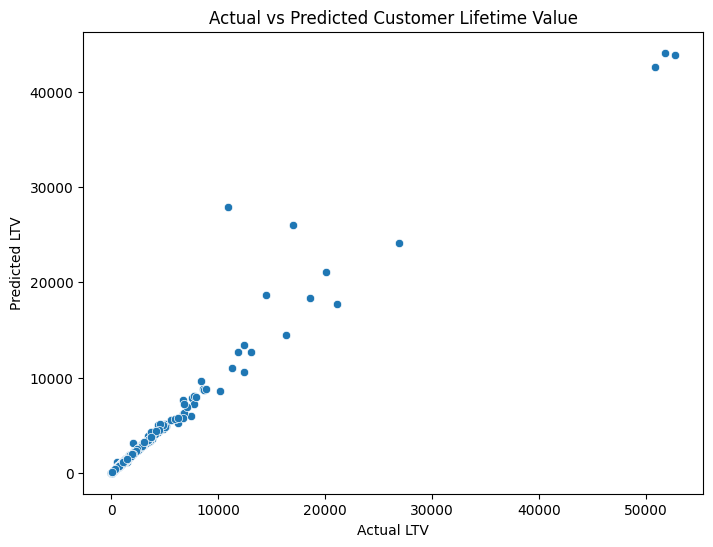

In [8]:

# Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.show()


## Save Final Predictions

In [9]:

# Save to CSV
rfm['Predicted_LTV'] = model.predict(X)
rfm[['CustomerID', 'Predicted_LTV']].to_csv("ltv_predictions.csv", index=False)
rfm.head()


,CustomerID,InvoiceDate,Recency,Frequency,Monetary,AOV,Predicted_LTV
1,12747.0,2011-12-07 14:34:00,2,11,4196.01,381.455455,4395.598145
2,12748.0,2011-12-09 12:20:00,1,224,29072.10,129.786161,29073.353516
3,12749.0,2011-12-06 09:56:00,4,8,3868.20,483.525000,3874.493164
4,12820.0,2011-12-06 15:12:00,3,4,942.34,235.585000,909.784119
5,12821.0,2011-05-09 15:51:00,214,1,92.72,92.720000,97.381622
